# Exemplo de como apresentar dados resumidos de um dataframe em um mapa com geopandas

Este documento utiliza dados no formato CSV que estão sendo lidos diretamente no endereço internet em um dataframe a partir da biblioteca pandas.

Também foi utilizado um shapefile da divisão política dos estados basileiros em um geodataframe criado a partir do GeoPandas.

A primeira linha de código força a leitura do Encoding.

A segunda linha permite apresentar os mapas contidos no notebook.

In [1]:
# encoding: utf-8

In [2]:
%matplotlib inline

In [3]:
# Declara a importação das bibliotecas necessárias
import geopandas as gpd
from shapely.geometry import Point
import pandas as pd

In [4]:
# Cria uma variável com o endereço URI do arquivo CSV
url = 'http://www.inpe.br/queimadas/dados-abertos/download/?utm_content=focos24h_Brasil&ref=focos24h_Brasil&utm_medium=landing-page&utm_source=landing-page&utm_campaign=dados-abertos'

In [5]:
# Prepara a leitura direta do CSV restringindo algumas colunas de interesse e forçando o formato de duas delas
df_focos = pd.read_csv(url, usecols=[2,3,4,5,6,7,8], dtype={"Data":str, "Hora":str} )

In [6]:
# converte e cria uma nova coluna do tipo date_time
df_focos["data_hora_gmt"] = pd.to_datetime(df_focos.Data + " " + df_focos.Hora)

In [7]:
# Apaga colunas desnecessárias
df_focos.drop(['Data', 'Hora'], axis=1, inplace=True)

In [8]:
# Apresenta uma visão geral do dataframe criado
df_focos.head()

,Lat,Long,Satelite,Municipio,Estado,data_hora_gmt
0,-3.870,-47.180,MSG-03,ULIANÓPOLIS,PARÁ,2018-10-24 00:05:05
1,-3.870,-47.230,MSG-03,ULIANÓPOLIS,PARÁ,2018-10-24 00:05:05
2,-3.620,-51.120,MSG-03,PACAJÁ,PARÁ,2018-10-24 00:05:08
3,-20.067,-41.919,METOP-B,SANTANA DO MANHUAÇU,MINAS GERAIS,2018-10-24 00:23:49
4,-20.065,-41.911,METOP-B,SANTANA DO MANHUAÇU,MINAS GERAIS,2018-10-24 00:23:49


In [10]:
# Prepara um novo atributo do tipo geometry utilizando a funcao Point do shapely para depois criar um geopandas
# esta variavel row eh soh pra ajudar a entender que ele vai pegar pra cada linha o atributo entre chaves

geometry = df_focos.apply(lambda row: Point(row['Long'], row['Lat']), axis=1)

# cria uma variavel com referencia ao sistema de projecao cartografica
crs = {'init': 'epsg:4326'}


# cria um geodataframe com o dataframe anterior
# neste caso usando o mesmo nome mais pode ser outro qualquer
gdf_focos = gpd.GeoDataFrame(df_focos, crs=crs, geometry=geometry)

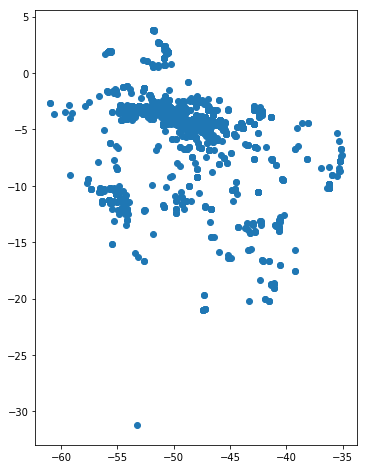

In [11]:
# Apresenta um mapa dos pontos
gdf_focos.plot(figsize=(16,8));

In [12]:
# Cria um dataframe resumindo a quantidade de focos por estados
tmp = gdf_focos.groupby(by="Estado").Estado.count()
summary = pd.DataFrame({"name_1":tmp.index, "nfocos":tmp.values})

summary.head()

,name_1,nfocos
0,ALAGOAS,33
1,AMAPÁ,89
2,AMAZONAS,9
3,BAHIA,74
4,CEARÁ,7


In [13]:
# Criação do Geodataframe a partir do shapefile
estados_br = gpd.read_file('./estados_br.shp')

In [14]:
# Apresenta o conteúdo do geodataframe
estados_br.head()

,id,id_0,id_1,name_0,name_1,geometry
0,374.0,33.0,29.0,Brasil,BAHIA,(POLYGON ((-39.66499999999996 -18.344027862548...
1,377.0,33.0,33.0,Brasil,RIO DE JANEIRO,(POLYGON ((-44.7299999999999 -23.3640278625487...
2,376.0,33.0,32.0,Brasil,ESPÍRITO SANTO,(POLYGON ((-41.6749999999999 -21.1290278625486...
3,383.0,33.0,51.0,Brasil,MATO GROSSO,(POLYGON ((-57.24499999999995 -17.809027862548...
4,384.0,33.0,52.0,Brasil,GOIÁS,(POLYGON ((-53.08499999999987 -17.089027862548...


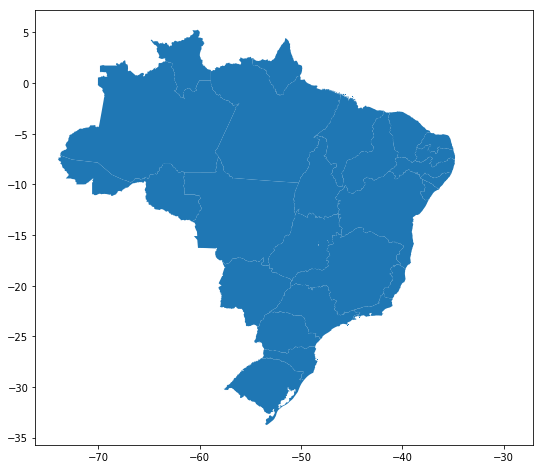

In [15]:
# Apresenta um mapa dos estados
estados_br.plot(figsize=(16, 8));

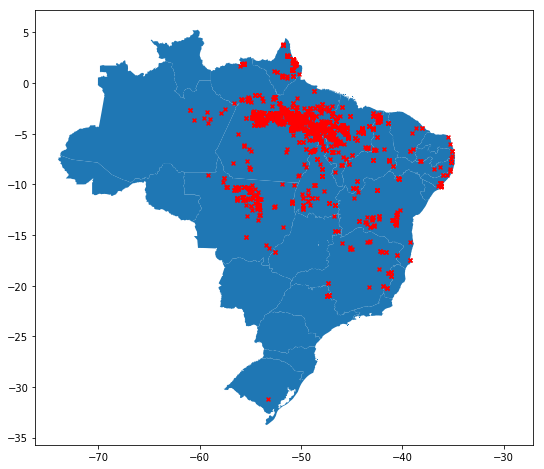

In [16]:
# Apresenta um mapa dos estados juntamente com os pontos
gdf_focos.plot(ax=estados_br.plot(figsize=(16, 8)), marker='x', color='red', markersize=15);

In [19]:
# realiza a união dos geodataframes considerando o campo em comúm
result = pd.merge(estados_br, summary, how="left", left_on=["name_1"], right_on=["name_1"] )
result["nfocos"].fillna(0, inplace=True)

result.head()

,id,id_0,id_1,name_0,name_1,geometry,nfocos
0,374.0,33.0,29.0,Brasil,BAHIA,(POLYGON ((-39.66499999999996 -18.344027862548...,74.0
1,377.0,33.0,33.0,Brasil,RIO DE JANEIRO,(POLYGON ((-44.7299999999999 -23.3640278625487...,0.0
2,376.0,33.0,32.0,Brasil,ESPÍRITO SANTO,(POLYGON ((-41.6749999999999 -21.1290278625486...,0.0
3,383.0,33.0,51.0,Brasil,MATO GROSSO,(POLYGON ((-57.24499999999995 -17.809027862548...,146.0
4,384.0,33.0,52.0,Brasil,GOIÁS,(POLYGON ((-53.08499999999987 -17.089027862548...,0.0


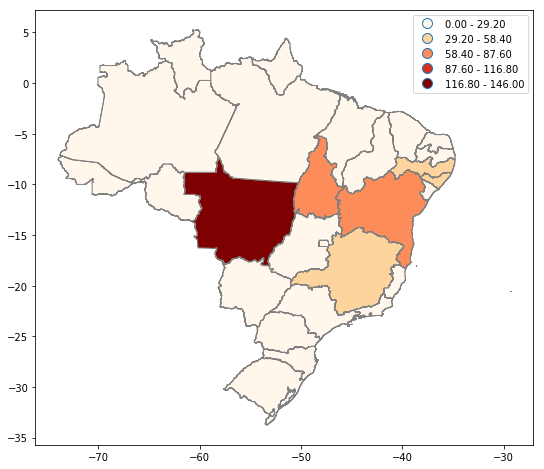

In [21]:
# Apresenta um mapa com cores conforme a quantidade de focos
result.plot(column="nfocos", scheme='Equal_Interval', cmap='OrRd', figsize=(16, 8), legend=True, edgecolor='gray');